In [1]:
import keras
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Flatten, Embedding, regularizers
from keras.layers import Conv1D, MaxPooling1D
from keras.layers.merge import Concatenate
from keras import optimizers
from keras.preprocessing import sequence
from keras import backend as K
from w2v import train_word2vec 
import pickle, datetime
import numpy as np
import difflib
from keras.datasets import imdb

Using TensorFlow backend.


# ------------------------------- Data Preprocessing -----------------------------------

In [2]:
max_words = 5000
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_words, start_char=None)

N_TRAIN = x_train.shape[0] 
N_TEST = x_test.shape[0]

In [3]:
max_sent_len = -1
for sent in x_train:
    max_sent_len = max(max_sent_len, len(sent))

for sent in x_test:
    max_sent_len = max(max_sent_len, len(sent))

print(max_sent_len)
max_sent_len = 400

2493


In [4]:
x_train = sequence.pad_sequences(x_train, maxlen=max_sent_len, padding="post", truncating="post")
x_test = sequence.pad_sequences(x_test, maxlen=max_sent_len, padding="post", truncating="post")

print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)

vocabulary = imdb.get_word_index()
vocabulary_inv = dict((v, k) for k, v in vocabulary.items())
vocabulary_inv[0] = "<PAD/>"

x_train shape: (25000, 400)
x_test shape: (25000, 400)


# -------------------------------- Training model  -----------------------------------

### Model Paremeters

In [5]:
model_type    = 'CNN-static'  # CNN-rand|CNN-non-static|CNN-static
embedding_dim = 25         # word2vec dim
vocab_size    = len(vocabulary_inv)
N_category    = 2

### Generate word2vec 

In [6]:
if model_type in ['CNN-non-static', 'CNN-static']:
    embedding_wts = train_word2vec( np.vstack((x_train, x_test)), 
                                    vocabulary_inv, num_features = embedding_dim)
    if model_type == 'CNN-static':
        x_train = embedding_wts[0][x_train]
        x_test  = embedding_wts[0][x_test]
#         x_valid = embedding_wts[0][x_valid]
        
elif model_type == 'CNN-rand':
    embedding_wts = None
    
else:
    raise ValueError("Unknown model type")

Load existing Word2Vec model '25features_1minwords_10context'


### Create model

In [7]:
filter_sizes = [3,4,5]
num_filters  = 50
dropout_prob = (0.5, 0.8)
hidden_dims  = 50
batch_size   = 64
l2_reg = 0.3

# Deciding dimension of input based on the model
input_shape = (max_sent_len, embedding_dim) if model_type == "CNN-static" else (max_sent_len,)
model_input = Input(shape = input_shape)

# Static model do not have embedding layer
if model_type == "CNN-static":
    z = Dropout(dropout_prob[0])(model_input)
else:
    z = Embedding(vocab_size, embedding_dim, input_length = max_sent_len, name="embedding", trainable=True)(model_input)
    z = Dropout(dropout_prob[0])(z)

# Convolution layers
z1 = Conv1D(    filters=num_filters, kernel_size=filter_sizes[0], 
                padding="valid", activation="relu", 
                strides=1)(z)
z1 = MaxPooling1D(pool_size = embedding_dim - filter_sizes[0] + 1)(z1)
z1 = Flatten()(z1)

z2 = Conv1D(    filters=num_filters, kernel_size=filter_sizes[1], 
                padding="valid", activation="relu", 
                strides=1)(z)
z2 = MaxPooling1D(pool_size=embedding_dim - filter_sizes[1] + 1)(z2)
z2 = Flatten()(z2)

z3 = Conv1D(    filters=num_filters, kernel_size=filter_sizes[2], 
                padding="valid", activation="relu",
                strides=1)(z)
z3 = MaxPooling1D(pool_size=embedding_dim - filter_sizes[2] + 1)(z3)
z3 = Flatten()(z3)

# Concatenate the output of all convolution layers
z = Concatenate()([z1, z2, z3])
z = Dropout(dropout_prob[1])(z)

z = Dense(hidden_dims, activation="relu")(z)
model_output = Dense(1, activation="sigmoid")(z)
    
model = Model(model_input, model_output)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 400, 25)       0                                            
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 400, 25)       0                                            
____________________________________________________________________________________________________
conv1d_1 (Conv1D)                (None, 398, 50)       3800                                         
____________________________________________________________________________________________________
conv1d_2 (Conv1D)                (None, 397, 50)       5050                                         
___________________________________________________________________________________________

### Train model 

In [ ]:
from sklearn.metrics import roc_auc_score
import time
import pylab as pl
from IPython import display
pl.style.use('ggplot')
%matplotlib inline

class Histories(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.acc = []
        self.loss = []
        self.val_loss = []
        self.val_acc = []

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        self.acc.append(logs['acc'])
        self.loss.append(logs['loss'])
        self.val_acc.append(logs['val_acc'])
        self.val_loss.append(logs['val_loss'])
        
        pl.hold(True)
        pl.plot(self.acc)
        pl.plot(self.loss)
        pl.plot(self.val_acc)
        pl.plot(self.val_loss)
        pl.legend(['Train acc','Train loss','Valid acc', 'Valid loss'], loc=2)
        display.clear_output(wait=True)
        display.display(pl.gcf())
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

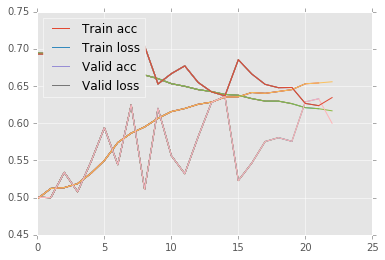

31s - loss: 0.6166 - acc: 0.6557 - val_loss: 0.6344 - val_acc: 0.5998
Epoch 24/50


In [ ]:
if model_type == "CNN-non-static":
    embedding_layer = model.get_layer("embedding")
    embedding_layer.set_weights(embedding_wts)

model.compile(loss="binary_crossentropy", optimizer=optimizers.SGD(0.1), metrics=["accuracy"])
histories = Histories()
res = model.fit(x_train, y_train, 
          batch_size = batch_size,
          epochs=50,
          validation_data=(x_test, y_test), verbose=2, callbacks=[histories])

In [ ]:
import os
os.system('say done')

### Computing Accuracy

In [12]:
# Final evaluation of the model
scores = model.evaluate(x_train, y_train, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
# Final evaluation of the model
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 92.16%
Accuracy: 87.91%


### Save the model

In [13]:
date = str(datetime.date.today() )
time = str(datetime.datetime.now().time())[:-7]

filename = '/home/shikhar/Datasets/Models/binary_' + model_type + '_' + date + '_' +time;
with open( filename, 'wb') as output:
    pickle.dump([model.get_config(), model.get_weights(), model.history.history], output, pickle.HIGHEST_PROTOCOL)

### Plot the results

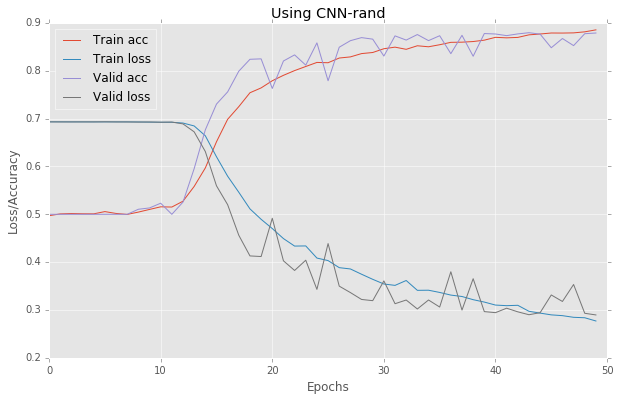

In [15]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.rcParams["figure.figsize"] = (10,6)
plt.plot(res.history['acc'])
plt.plot(res.history['loss'])
plt.plot(res.history['val_acc'])
plt.plot(res.history['val_loss'])
plt.legend(['Train acc','Train loss','Valid acc', 'Valid loss'], loc=2)
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.title('Using '+ model_type)
# imgName = 'Images/' + model_type + '_' + date + '_' + time + '.jpg'
# plt.savefig( imgName, dpi= 200, bbox_inches='tight', transparent=False)
plt.show()

### Continue from a pretrained model

In [11]:
# Loading saved data
import pickle

filename = '/home/shikhar/Datasets/Models/binaryBKP_CNN-rand_continued_2017-04-07_16:18:46'
with open( filename, 'rb') as input:
    out = pickle.load(input)

model.compile(loss="binary_crossentropy", optimizer=optimizers.SGD(.01), metrics=["accuracy"])
model.set_weights(out[1])

In [12]:
res = model.fit(x_train, y_train,
          batch_size = batch_size,
          epochs=50,
          validation_data=(x_test, y_test), verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/50
32s - loss: 0.1985 - acc: 0.9200 - val_loss: 0.2948 - val_acc: 0.8785
Epoch 2/50
32s - loss: 0.1953 - acc: 0.9214 - val_loss: 0.2962 - val_acc: 0.8779
Epoch 3/50
31s - loss: 0.1935 - acc: 0.9212 - val_loss: 0.2965 - val_acc: 0.8785
Epoch 4/50
33s - loss: 0.1891 - acc: 0.9238 - val_loss: 0.2995 - val_acc: 0.8764
Epoch 5/50
33s - loss: 0.1875 - acc: 0.9255 - val_loss: 0.2999 - val_acc: 0.8766
Epoch 6/50
33s - loss: 0.1947 - acc: 0.9224 - val_loss: 0.2974 - val_acc: 0.8778
Epoch 7/50
37s - loss: 0.1928 - acc: 0.9226 - val_loss: 0.2994 - val_acc: 0.8769
Epoch 8/50
32s - loss: 0.1890 - acc: 0.9228 - val_loss: 0.2974 - val_acc: 0.8784
Epoch 9/50
34s - loss: 0.1905 - acc: 0.9223 - val_loss: 0.2980 - val_acc: 0.8781
Epoch 10/50
34s - loss: 0.1851 - acc: 0.9243 - val_loss: 0.3005 - val_acc: 0.8772
Epoch 11/50
34s - loss: 0.1892 - acc: 0.9236 - val_loss: 0.3019 - val_acc: 0.8751
Epoch 12/50
33s - loss: 0.1878 - acc: 0.9262 - val_loss: 

### Save the model (marking as continued)

In [14]:
date = str(datetime.date.today() )
time = str(datetime.datetime.now().time())[:-7]

filename = '/home/shikhar/Datasets/Models/binaryBKP_' + model_type + '_continued_' + date + '_' +time;
with open( filename, 'wb') as output:
    pickle.dump([model.get_config(), model.get_weights(), model.history.history], output, pickle.HIGHEST_PROTOCOL)

In [13]:
import os
os.system('say done')

256

In [22]:
files = [
    'binary_CNN-rand_2017-04-07_15:57:36',
    'binaryBKP_CNN-rand_continued_2017-04-07_16:18:46',
    'binaryBKP_CNN-rand_continued_2017-04-07_22:58:50'
]

In [23]:
train_acc, train_loss, val_acc, val_loss = [],[],[],[]

for file in files:
    filename = '/home/shikhar/Datasets/Models/'  + file
    with open( filename, 'rb') as input:
        out = pickle.load(input)
    train_acc += out[2]['acc']
    train_loss += out[2]['loss']
    val_acc += out[2]['val_acc']
    val_loss += out[2]['val_loss']

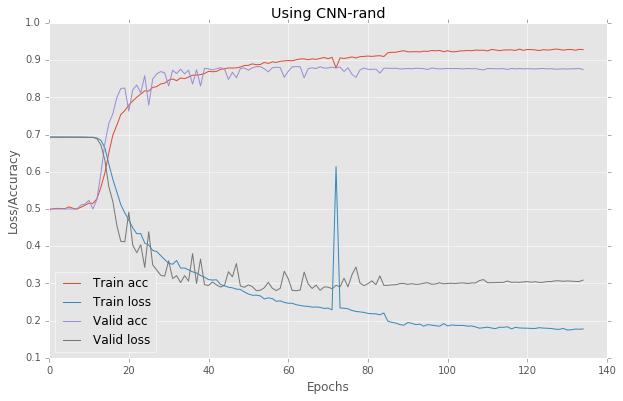

In [25]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (10,6)
plt.plot(train_acc)
plt.plot(train_loss)
plt.plot(val_acc)
plt.plot(val_loss)
plt.legend(['Train acc','Train loss','Valid acc', 'Valid loss'], loc=3)
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.title('Using '+ model_type)
date = str(datetime.date.today() )
time = str(datetime.datetime.now().time())[:-7]
imgName = 'Images/' + model_type + '_' + date + '_' + time + '.jpg'
plt.savefig( imgName, dpi= 200, bbox_inches='tight', transparent=False)
plt.show()